# System analysis (Micro)

In [1]:
import pickle
import analysis_utils
import plot_utils
from collections import defaultdict, OrderedDict
import math
from scipy.stats import pearsonr, spearmanr
import numpy as np
from scipy.stats import kendalltau
import pandas as pd
from scipy.stats import entropy
from copy import deepcopy
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})


import seaborn as sns
sns.set_style("whitegrid")

In [3]:
debug=False

### 1) Load data from BIN files

In [4]:
n3_title='n3'
aida_title='aida'
titles=[aida_title, n3_title]
systems=['agdistis', 'spotlight', 'wat']

In [5]:
### Load data from disk
system_data_articles={}
for system in systems:
    system_data_articles[system]={}
    for data_title in titles:
        with open('bin/%s_%s.bin' % (data_title, system), 'rb') as outfile:
            system_data_articles[system][data_title]=pickle.load(outfile)

#### [DEBUG-only] Store agdistis output to a file

In [6]:
if debug:
    with open('debug/agdmag_aida_debug.tsv', 'w') as w:
        w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
        for article in aida_agd_articles:
            for mention in article.entity_mentions:
                if mention.sys_link.startswith('http://aksw.org/'):
                    mention.sys_link = '--NME--'

                a_row=[article.collection, str(article.identifier), 
                       str(mention.begin_index), str(mention.end_index), 
                       mention.mention, mention.gold_link, 
                       mention.sys_link]
                w.write('\t'.join(a_row) + '\n')

**1.1. Pick dataset**

In [7]:
system_articles = {}

for system in systems:
    system_articles[system]=set()
    for data_title in titles: 
        system_articles[system] |= system_data_articles[system][data_title]

**1.2. Normalize AGDISTIS NILs given as custom AKSW URIs **

In [8]:
for article in system_articles['agdistis']:
    for mention in article.entity_mentions:
        if mention.sys_link.startswith('http://aksw.org/'):
            mention.sys_link = '--NME--'


**1.3.Normalize forms to lower-case (disabled for now)**

In [9]:
if debug:
    for system in systems:
        for article in system_articles[system]:
            for mention in article.entity_mentions:
                mention.mention=mention.mention.lower()
                print(mention.mention)

### 2) Performance

<span style="background-color:lightgreen">Section 5.1. of the paper</span>

#### 2.1. Overall

In [10]:
skip_nils=True
skip_nonnils=False

In [11]:
all_sys_accs = defaultdict(dict)
for system in systems:
    print(system.upper())
    sys_acc=analysis_utils.overall_performance_prf(system_articles[system], 
                                               skip_nils, 
                                               skip_nonnils)
    all_sys_accs[system]['overall']=sys_acc
#    scores.append(['overall', system, sys_acc])
    print(sys_acc)
    print()


AGDISTIS
17064 8991 11927
0.6549222797927461 0.5885964609706461 0.6199905533553755
0.6199905533553755

SPOTLIGHT
21150 5505 7841
0.7934721440630276 0.7295367527853471 0.7601624555224096
0.7601624555224096

WAT
19027 2420 9964
0.8871637058796102 0.6563071297989032 0.7544708354811849
0.7544708354811849



#### 2.2. Only forms that are interpretted as NILs and not-NILs

In [12]:
if debug:
    for system in systems:
        interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
        ambiguity={}
        for form,meanings in interpretations.items():
            ambiguity[form]=len(meanings)

        nil_nonnil_forms=set()
        for form, amb in ambiguity.items():
            if amb>1:
                if '--NME--' in interpretations[form]:
                    nil_nonnil_forms.add(form)

        nn_f_acc=analysis_utils.compute_prf_on_selection(system_articles[system], nil_nonnil_forms)
        print(system, nn_f_acc)
        all_sys_accs[system]['forms with nils & non-nils']=nn_f_acc
    #    scores.append(['forms with nils & non-nils', system, nn_f_acc])

#### 2.3. Only ambiguous forms

In [13]:
for system in systems:
    interpretations, references = analysis_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=analysis_utils.compute_prf_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    all_sys_accs[system]['ambiguous forms']=amb_f_acc
#    scores.append(['ambiguous forms', system, amb_f_acc])

4369 4830 5662
0.4749429285791934 0.435549795633536 0.4543941757670307
agdistis 0.4543941757670307
6502 3446 3498
0.6535987133092079 0.6502 0.6518949268097053
spotlight 0.6518949268097053
6108 1665 3922
0.785796989579313 0.6089730807577268 0.6861764871089142
wat 0.6861764871089142


** 2.4. Prepare and plot **

In [14]:
scores=analysis_utils.prepare_scores_to_plot(all_sys_accs)

['overall', 'ambiguous forms']
['AGDISTIS', 'SPOTLIGHT', 'WAT']
width: 0.3
evaluation: overall
0.6199905533553755
0.7601624555224096
0.7544708354811849
evaluation: ambiguous forms
0.4543941757670307
0.6518949268097053
0.6861764871089142


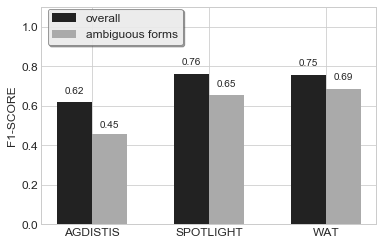

In [15]:
plot_utils.plot_scores(scores, title='Scores of systems')
#plot_scores(scores, title='Scores of systems')

### 3) Baselines

In [16]:
baseline_articles = {}

In [17]:
freq_system='x freq baseline'
random_system='x random baseline'

totals=analysis_utils.get_freq_totals(system_articles[systems[0]],
                                      set(),
                                      ambiguous_only=False
                                     )
freq_baseline_articles=deepcopy(system_articles['agdistis'])
pr_baseline_articles=deepcopy(system_articles['agdistis'])
random_baseline_articles=deepcopy(system_articles['agdistis'])


In [18]:


form_to_mostfreq=defaultdict(lambda: '--NME--')
form_to_highest_pr = defaultdict(lambda: '--NME--')
for form, dist in totals.items():
    key_max = max(dist.keys(), key=(lambda k: dist[k]))
    form_to_mostfreq[form]=key_max

In [19]:
for article in freq_baseline_articles:
    for mention in article.entity_mentions:
        mention.sys_link=form_to_mostfreq[mention.mention]
        
for article in random_baseline_articles:
    for mention in article.entity_mentions:
        if mention.mention in totals.keys() and totals[mention.mention].keys():
            key_random=random.choice(list(totals[mention.mention].keys()))
        else:
            key_random='--NME--'
        mention.sys_link=key_random
        
baseline_articles[freq_system]=freq_baseline_articles
baseline_articles[random_system]=random_baseline_articles

In [20]:
for baseline, articles in baseline_articles.items():
    sys_acc=analysis_utils.overall_performance_prf(articles, skip_nils=True, skip_nonnils=False)
    print(sys_acc)
    all_sys_accs[baseline]['overall']=sys_acc


27089 1902 1902
0.9343934324445518 0.9343934324445518 0.9343934324445516
0.9343934324445516
22799 6192 6192
0.7864164740781622 0.7864164740781622 0.7864164740781622
0.7864164740781622


In [21]:
for baseline, articles in baseline_articles.items():
    amb_f_acc=analysis_utils.compute_prf_on_selection(articles, ambiguous_forms)
    all_sys_accs[baseline]['ambiguous forms']=amb_f_acc
    if debug: 
        nn_f_acc=analysis_utils.compute_prf_on_selection(articles, nil_nonnil_forms)
        all_sys_accs[baseline]['forms with nils & non-nils']=nn_f_acc

8092 2099 1902
0.7940339515258561 0.8096858114868921 0.8017835026009412
3802 6389 6192
0.373074281228535 0.3804282569541725 0.3767153827099331


### 4) Prepare the data needed to compare frequency/popularity and performance

**4.1. Compute P, R and F1 per form and instance**

In [22]:
def evaluate_per_form_or_instance(articles, which='form', skip_nils=True, ambiguous_only=False, ambiguous_forms=None):
    """
    Evaluate ranks for precision, recall, and F1-score.
    """
    tps=defaultdict(int)
    fns=defaultdict(int)
    fps=defaultdict(int)
   

    all_cases=set()
    for article in articles:
        for mention in article.entity_mentions:
                form=mention.mention
                meaning=mention.gold_link
                sys_meaning=mention.sys_link
                if skip_nils and meaning=='--NME--':
                    continue
                if ambiguous_only and form not in ambiguous_forms:
                    continue
                if which=='form':
                    factor_sys=form
                    factor_gold=form
                else:
                    factor_gold=meaning
                    factor_sys=sys_meaning
                all_cases.add(factor_gold)
                all_cases.add(factor_sys)
                if sys_meaning==meaning:
                    tps[factor_gold]+=1
                else:
                    if meaning and meaning!='--NME--':
                        fns[factor_gold]+=1
                    if sys_meaning and sys_meaning!='--NME--':
                        fps[factor_sys]+=1

    prec={}
    recall={}
    f1={}

    for factor in all_cases:
        if tps[factor]+fps[factor]>0:
            prec[factor]=tps[factor]/(tps[factor]+fps[factor])
        else:
            prec[factor]=0.0
        if tps[factor]+fns[factor]>0:
            recall[factor]=tps[factor]/(tps[factor]+fns[factor])
        else:
            recall[factor]=0.0
        if prec[factor]+recall[factor]>0:
            f1[factor]=2*prec[factor]*recall[factor]/(prec[factor]+recall[factor])
        else:
            f1[factor]=0.0
    return prec, recall, f1

In [50]:
prec_by_form = {system: defaultdict(float) for system in systems}
recall_by_form = {system: defaultdict(float) for system in systems}
f1_by_form = {system: defaultdict(float) for system in systems}

for system in systems:
    prf = evaluate_per_form_or_instance(system_articles[system], 'form', 
                                        ambiguous_only=True, 
                                        ambiguous_forms=ambiguous_forms)
    prec_by_form[system]=prf[0]
    recall_by_form[system]=prf[1]
    f1_by_form[system]=prf[2]

In [51]:
prec_by_instance = {system: defaultdict(float) for system in systems}
recall_by_instance = {system: defaultdict(float) for system in systems}
f1_by_instance = {system: defaultdict(float) for system in systems}

for system in systems:
    prf = evaluate_per_form_or_instance(system_articles[system], 'instance', 
                                        ambiguous_only=True, 
                                        ambiguous_forms=ambiguous_forms)
    prec_by_instance[system]=prf[0]
    recall_by_instance[system]=prf[1]
    f1_by_instance[system]=prf[2]

**4.2. Obtain frequency distributions for forms and instances**

In [25]:
instance_frequencies, form_frequencies=analysis_utils.get_mention_counts(system_articles[systems[0]])

**4.3. Obtain PageRank values**

In [52]:
skip_zeros=True
pagerank_frequency, pr_uniq, uri_pr = analysis_utils.get_pageranks(system_articles['spotlight'],
                                                                     skip_zeros=skip_zeros,
                                                                     ambiguous_only=True,
                                                                      ambiguous_forms=ambiguous_forms)

**4.4. Prepare entropy values**

In [46]:
form_entropies={}
for form in ambiguous_forms:
    counts=analysis_utils.get_form_counts(system_articles['spotlight'], form)
    counts=list(counts)
    form_entropies[form]=entropy(counts ,base=len(counts))

### 5) Compute Correlations between frequency/popularity and performance

<span style="background-color:lightgreen">Section 5.2. of the paper</span>

** 5.1. Compute correlation between form frequency and performance**

In [53]:
agg_per_frequency=defaultdict(set)
for form, frequency in form_frequencies.items():
    agg_per_frequency[frequency].add(form)

for system in systems:
    dist1=[]
    dist2=[]
    for frequency, forms in sorted(agg_per_frequency.items()):
        f1_values=[]
        for form in forms:
            try:
                f1_values.append(f1_by_form[system][form])
            except KeyError:
                continue
        if f1_values:
            dist1.append(frequency)
            dist2.append(np.mean(f1_values))
    correlation, significance = spearmanr(dist1, dist2)
    print(system.upper())
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: 0.3655401619587331 . Significance:  0.0007917661878880399
SPOTLIGHT
The Spearman correlation between X and Y is: 0.3986517387383962 . Significance:  0.0002276724455046566
WAT
The Spearman correlation between X and Y is: 0.5831220817735315 . Significance:  1.1150723857658424e-08


** 5.2. Compute correlation between instance frequency and performance**

In [54]:
agg_inst_per_frequency=defaultdict(set)
for instance, frequency in instance_frequencies.items():
    agg_inst_per_frequency[frequency].add(instance)

for system in systems:
    dist1=[]
    dist2=[]
    for frequency, instances in sorted(agg_inst_per_frequency.items()):
        f1_values=[]
        for instance in instances:
            try:
                f1_values.append(f1_by_instance[system][instance])
            except KeyError:
                continue
        if f1_values:
            dist1.append(frequency)
            dist2.append(np.mean(f1_values))
    correlation, significance = spearmanr(dist1, dist2)
    print(system.upper())
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: 0.410452552413578 . Significance:  7.131874049539861e-05
SPOTLIGHT
The Spearman correlation between X and Y is: 0.4195963106422938 . Significance:  4.7142791022930335e-05
WAT
The Spearman correlation between X and Y is: 0.531948173943996 . Significance:  9.637501841352559e-08


** 5.3. Compute correlation between instance PageRank and performance**

In [56]:
agg_inst_per_pr=defaultdict(set)
for instance, i_pr in uri_pr.items():
    agg_inst_per_pr[i_pr].add(instance)

for system in systems:
    dist1=[]
    dist2=[]
    for i_pr, instances in sorted(agg_inst_per_pr.items()):
        f1_values=[]
        for instance in instances:
            try:
                f1_values.append(f1_by_instance[system][instance])
            except KeyError:
                continue
        if f1_values:
            dist1.append(i_pr)
            dist2.append(np.mean(f1_values))
    correlation, significance = spearmanr(dist1, dist2)
    print(system.upper())
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: 0.33103081493308234 . Significance:  6.244287282214104e-10
SPOTLIGHT
The Spearman correlation between X and Y is: 0.3107839756944949 . Significance:  7.239154218648365e-09
WAT
The Spearman correlation between X and Y is: 0.42138336232241747 . Significance:  1.008482817254364e-15


### 6) Entropy

<span style="background-color:lightgreen">Section 5.4. of the paper</span>


**6.1. Plot F1-scores per entropy class**

In [31]:
forms_per_rentropy=defaultdict(set)
for form, entr in form_entropies.items():
    rounded_entropy=round(entr,1)
    forms_per_rentropy[rounded_entropy].add(form)

AGDISTIS
1019 532 950
0.6569954867827208 0.5175215845606908 0.5789772727272727
826 249 294
0.7683720930232558 0.7375 0.7526195899772209
444 303 365
0.5943775100401606 0.5488257107540173 0.5706940874035991
454 532 555
0.460446247464503 0.4499504459861249 0.4551378446115288
366 562 603
0.39439655172413796 0.37770897832817335 0.385872430152873
241 525 579
0.31462140992167104 0.2939024390243902 0.30390920554854983
244 725 794
0.2518059855521156 0.2350674373795761 0.24314897857498757
279 490 518
0.36280884265279584 0.35006273525721454 0.3563218390804598
222 381 403
0.3681592039800995 0.3552 0.36156351791530944
274 531 601
0.3403726708074534 0.31314285714285717 0.3261904761904762
SPOTLIGHT
1542 409 426
0.7903639159405433 0.7835365853658537 0.7869354427149784
871 227 248
0.7932604735883424 0.7783735478105451 0.7857465042850699
638 158 172
0.8015075376884422 0.7876543209876543 0.7945205479452055
712 290 297
0.7105788423153693 0.7056491575817642 0.7081054201889607
554 414 407
0.5723140495867769

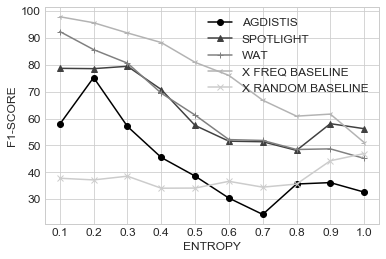

In [32]:

fig = plt.figure()
cnt=0
c=['o', '^', '+', '3', 'x']
clr=['0.0', '0.25', '0.5', '0.7', '0.8']


for system in systems:
    w=open('debug/entropy_%s.tsv' % system, 'w')
    xs=[]
    ys=[]
    print(system.upper())
    for rentropy, forms_set in sorted(forms_per_rentropy.items()):
        f1=analysis_utils.compute_prf_on_selection(system_articles[system], forms_set)
        fc=0
        for frm in sorted(list(forms_set)):
            interps=interpretations[frm]
            if fc==0:
                w.write('%f\t%f\t%s\t%s\n' % (rentropy, f1, frm, ','.join(interps)))
            else:
                w.write(' \t \t%s\t%s\n' % (frm, ','.join(interps)))
            fc+=1
        w.write('\n')
        xs.append(rentropy)
        ys.append(f1*100.0)
    plt.plot(xs, ys, "%s-" % c[cnt], color=clr[cnt], label=system.upper())
    cnt+=1
    w.close()
    
for baseline, articles in baseline_articles.items():    
    xs=[]
    ys=[]
    print(baseline.upper())
    for rentropy, forms_set in sorted(forms_per_rentropy.items()):
        f1=analysis_utils.compute_prf_on_selection(articles, forms_set)
        xs.append(rentropy)
        ys.append(f1*100.0)
    plt.plot(xs, ys, "%s-" % c[cnt], color=clr[cnt], label=baseline.upper())
    cnt+=1
    
    
plt.legend()
plt.xlabel('ENTROPY')
plt.ylabel('F1-SCORE')
plt.xticks(xs)
 
plt.show()

save=True
if save:
    fig.savefig('img/entropy_f1.png')


**6.2. Compute correlation between form entropy and P/R/F1**

In [33]:
for metric in [prec_by_form, recall_by_form, f1_by_form]:
    for system in systems:
        print(system.upper())
    
        dist1, dist2 = analysis_utils.prepare_lists(metric[system], form_entropies)
        correlation, significance = spearmanr(dist1, dist2)
        print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

AGDISTIS
The Spearman correlation between X and Y is: -0.08312164771306858 . Significance:  0.06119382124616348
SPOTLIGHT
The Spearman correlation between X and Y is: -0.23103931306007783 . Significance:  1.394701072498865e-07
WAT
The Spearman correlation between X and Y is: -0.2614479059771961 . Significance:  2.1961874070858405e-09
AGDISTIS
The Spearman correlation between X and Y is: -0.06648672594860974 . Significance:  0.1345235641141916
SPOTLIGHT
The Spearman correlation between X and Y is: -0.23040660272681132 . Significance:  1.511749410116273e-07
WAT
The Spearman correlation between X and Y is: -0.2889102155066703 . Significance:  3.185488442023032e-11
AGDISTIS
The Spearman correlation between X and Y is: -0.07622042947383413 . Significance:  0.08612791534222165
SPOTLIGHT
The Spearman correlation between X and Y is: -0.23008360258617258 . Significance:  1.5750992154105367e-07
WAT
The Spearman correlation between X and Y is: -0.30580247227378793 . Significance:  1.8556759126650

**The average correlation across systems between F1-score and entropy is -0.20518622158**

### 7) Correlation between instance ranks (of a form) and performance

<span style="background-color:lightgreen">Section 5.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [34]:
interpretations=defaultdict(set)
for article in system_articles['spotlight']:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [35]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [36]:
def rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=None, ambiguous_only=True, factor='freq'):

    print(factor)
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(14,3))
    p={}
    r={}
    f1={}

    for system in systems:
        w=open('debug/%srank_%s.tsv' % (factor, system), 'w')
        rank_tuples=analysis_utils.prepare_ranks(system_articles[system], 
                                                  ambiguous_forms,
                                                  uri_pr=uri_pr,
                                                  ambiguous_only=ambiguous_only, 
                                                  factor=factor)
        for rank in sorted(rank_tuples.keys()):
            w.write('%d\n' % rank)
            for t in rank_tuples[rank]:
                w.write(' \t%s\t%s\n' % (t[0], t[1]))
            w.write('\n')
        w.close()
        #print(rank_tuples)
        p[system], r[system], f1[system] = analysis_utils.evaluate_ranks(system_articles[system], 
                                                          rank_tuples)
        
        print()

    plot_utils.plot_prf(p, systems, axs[0], title="PRECISION")
    plot_utils.plot_prf(r, systems, axs[1], title="RECALL")
    plot_utils.plot_prf(f1, systems, axs[2], title="F1-SCORE")

    plt.show()

    fig.savefig('img/accuracy_per_%s_rank.png' % factor, bbox_inches='tight')

freq
tp defaultdict(<class 'int'>, {1: 3878, 3: 44, 2: 408, 5: 1, 6: 1})
fp defaultdict(<class 'int'>, {3: 467, 1: 645, 2: 1008, 6: 157, 5: 36, 4: 1})
fn defaultdict(<class 'int'>, {2: 1089, 3: 242, 1: 4214, 5: 20, 4: 78, 6: 8, 7: 3, 8: 2, 9: 2, 11: 1, 12: 1, 10: 2})
precision {1: 0.857395533937652, 2: 0.288135593220339, 3: 0.08610567514677103, 4: 0.0, 5: 0.02702702702702703, 6: 0.006329113924050633, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

recall {1: 0.47923875432525953, 2: 0.2725450901803607, 3: 0.15384615384615385, 4: 0.0, 5: 0.047619047619047616, 6: 0.1111111111111111, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

f1 {1: 0.614823622671423, 2: 0.2801235839340886, 3: 0.11041405269761606, 4: 0.0, 5: 0.034482758620689655, 6: 0.011976047904191616, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}


tp defaultdict(<class 'int'>, {1: 5527, 3: 131, 2: 791, 6: 2, 4: 36, 5: 7, 10: 2})
fp defaultdict(<class 'int'>, {1: 409, 4: 244, 2: 781, 3: 314, 5: 13, 6: 1, 10: 3})
fn def

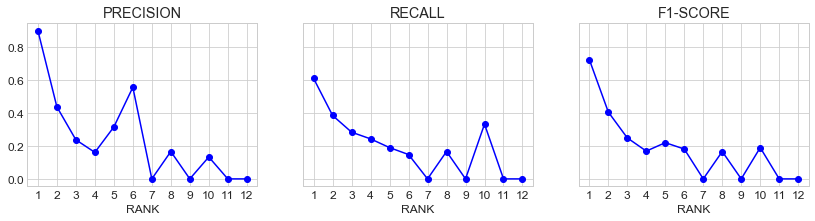

In [37]:
rank_analysis(systems, system_articles, ambiguous_forms, ambiguous_only=True, factor='freq')

#### 7.3 PR ranks


pr
tp defaultdict(<class 'int'>, {1: 3992, 2: 299, 3: 21, 4: 18})
fp defaultdict(<class 'int'>, {1: 1773, 2: 372, 3: 166, 4: 3})
fn defaultdict(<class 'int'>, {3: 531, 1: 2810, 2: 2077, 4: 103, 5: 103, 11: 5, 6: 17, 10: 5, 9: 3, 7: 2, 8: 1, 12: 1})
precision {1: 0.6924544666088465, 2: 0.4456035767511177, 3: 0.11229946524064172, 4: 0.8571428571428571, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

recall {1: 0.5868862099382535, 2: 0.12584175084175084, 3: 0.03804347826086957, 4: 0.1487603305785124, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

f1 {1: 0.6353147131375825, 2: 0.19625861503117817, 3: 0.05683355886332882, 4: 0.2535211267605634, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}


tp defaultdict(<class 'int'>, {2: 1276, 1: 4904, 3: 160, 4: 49, 5: 87, 6: 13, 11: 5, 7: 2})
fp defaultdict(<class 'int'>, {1: 536, 2: 621, 5: 97, 3: 219, 4: 209, 6: 80, 7: 3})
fn defaultdict(<class 'int'>, {3: 394, 2: 1101, 1: 1897, 4: 70, 5:

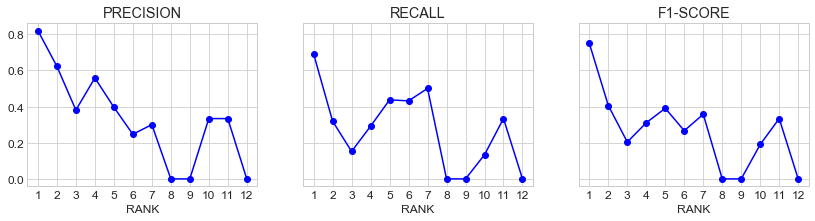

In [38]:
rank_analysis(systems, system_articles, ambiguous_forms, uri_pr=uri_pr, ambiguous_only=True, factor='pr')

### 8) Ambiguity and frequency together against accuracy

<span style="background-color:lightgreen">Section 5.3. of the paper</span>

In [39]:
def heatmap_me(AMB, FREQ, ACC, system, a, ylbl='', cbar=False, yticks=[]):
    data = pd.DataFrame({'AMBIGUITY': AMB, 'FREQ': FREQ, 'ACC': ACC})
    data_pivoted = data.pivot("FREQ", "AMBIGUITY", "ACC")
#    fig=plt.figure(figsize = (12,7))
    ax = sns.heatmap(data_pivoted, annot=True, linewidths=.5, ax=a,cbar=cbar,fmt='g', yticklabels=yticks)
    ax.set_ylabel(ylbl)
    ax.set_title(system.upper())
    for _, spine in ax.spines.items():
        spine.set_edgecolor('darkblue')
        spine.set_visible(True)
#    plt.show()
#    fig.savefig('img/%s_amb_frequency_acc.png' % system)

In [40]:
def split_forms_per_amb_freq_pair(ambiguity, forms_by_log_count):
    af_pairs=defaultdict(set)
    for log_freq, forms in forms_by_log_count.items():
        for form in forms:
            amb=ambiguity[form]
            rounded_freq=round(log_freq)
            af_pairs[(amb, rounded_freq)].add(form)
    return af_pairs

In [41]:
def evaluate_af_pairs(af_pairs, articles, skip_nils=True):
    
    tp=defaultdict(int)
    fn=defaultdict(int)
    fp=defaultdict(int)
    
    counts=defaultdict(set)
    for article in articles:
        for mention in article.entity_mentions:
            gold = mention.gold_link
            syslink = mention.sys_link
            form = mention.mention
            if skip_nils and gold=='--NME--':
                continue
            this_pair=None
            for pair, forms in af_pairs.items():
                if form in forms:
                    this_pair=pair
            if not this_pair:
                continue
            else:
                counts[this_pair].add(form)
            if gold==syslink:
                tp[this_pair]+=1
            else:
                if syslink!='--NME--':
                    fp[this_pair]+=1
                fn[this_pair]+=1
    
    agg_counts={}
    for pair, forms in counts.items():
        agg_counts[pair]=len(forms)
    
    prec=defaultdict(float)
    recall=defaultdict(float)
    f1=defaultdict(int)
    
    for pair in af_pairs.keys():
        prec[pair]=tp[pair]/(tp[pair]+fp[pair])
        recall[pair]=tp[pair]/(tp[pair]+fn[pair])
        if prec[pair]+recall[pair]>0:
            f1[pair]=int(100.0*2*prec[pair]*recall[pair]/(prec[pair]+recall[pair]))
        else:
            f1[pair]=0
    
    return f1, agg_counts

In [42]:
forms_by_count = analysis_utils.compute_counts_by_form(system_articles['wat'])
forms_by_log_count=analysis_utils.counts_to_log_counts(forms_by_count)
freq_intervals = analysis_utils.get_freq_intervals(forms_by_count)

total_per_form = analysis_utils.get_freq_totals(system_articles[systems[0]], ambiguous_forms, ambiguous_only=False)
af_pairs=split_forms_per_amb_freq_pair(ambiguity, forms_by_log_count)

In [43]:
def plot_heatmap(data, cnt, freq_intervals, axs=None, system=''):
    AMB=[]
    FREQ=[]
    ACC=[]
    yticks=[]
    for this_pair, val in data.items():

        ACC.append(val)
        AMB.append(this_pair[0])
        mn=freq_intervals[this_pair[1]][0]
        mx=freq_intervals[this_pair[1]][1]
        FREQ.append((mn,mx))
    if cnt>0:
        ylbl=''
    else:
        ylbl='FREQUENCY'
    
    for cpl in sorted(list(set(FREQ))):
        yticks.append('[ %d, %d ]' % (cpl[0], cpl[1]))
    
    heatmap_me(AMB, FREQ, ACC, system, axs[cnt], cbar=(cnt==2), ylbl=ylbl, yticks=yticks)


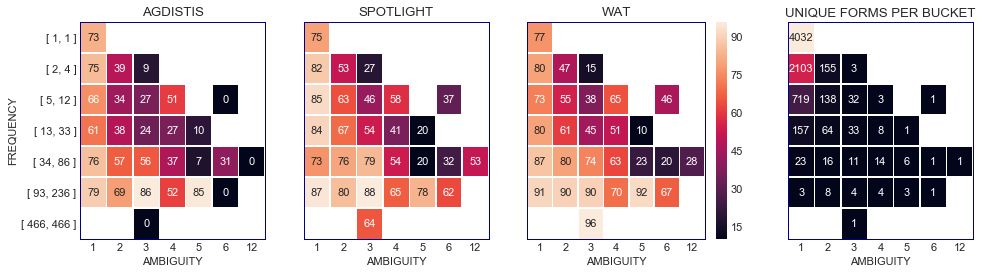

In [44]:
plt.rcParams.update({'font.size': 11})

fig, axs = plt.subplots(1,4, sharey=True, figsize=(16,4), gridspec_kw={'width_ratios':[1,1,1.2,1]})
cnt=0

for system in systems:
    
    f1s, counts = evaluate_af_pairs(af_pairs, system_articles[system])
    
    plot_heatmap(f1s, cnt, freq_intervals, axs, system)

    cnt+=1
    
plot_heatmap(counts, cnt, freq_intervals, axs, 'unique forms per bucket')
    
plt.show()
fig.savefig('img/amb_frequency_acc.png')